In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import requests
import datetime
from matplotlib.lines import Line2D
import matplotlib as mpl
import copy
import math
import pickle

from tqdm.auto import tqdm
from datetime import timedelta, date
import time
import os
import numbers

import warnings
warnings.filterwarnings('ignore')

In [2]:
from jax import random
import numpyro
import numpyro.distributions as dist

import scenario_generator.curated as curated
import scenario_generator.mcmc_forecast as mcmc
import scenario_generator.utils as u

from mechafil.sim import run_simple_sim
from mechafil.data import get_historical_network_stats, get_sector_expiration_stats, \
    query_starboard_sector_expirations, get_cum_capped_qa_power
from mechafil.power import forecast_power_stats, build_full_power_stats_df
from mechafil.vesting import compute_vesting_trajectory_df
from mechafil.minting import compute_minting_trajectory_df, \
    network_time, cum_baseline_reward
from mechafil.supply import forecast_circulating_supply_df

## NOTE: This code uses mechaFIL in a non-standard way. To reproduce the results,
#   the `sdm_take2_analysis` branch of mechaFIL needs to be used - not the main branch.
#   https://github.com/protocol/filecoin-mecha-twin/tree/sdm_take2_analysis
# This comment is relevant as of 3-Jan-2023.

In [3]:
from pycoingecko import CoinGeckoAPI
import datetime as dt

cg = CoinGeckoAPI()

In [4]:
offline_folder = 'offline_info'
results_folder = 'results'
os.makedirs(offline_folder, exist_ok=True)
os.makedirs(results_folder, exist_ok=True)

In [5]:
fpp = os.path.join(offline_folder, 'historical_inputs.pkl')
if os.path.exists(fpp):
    with open(fpp, 'rb') as f:
        z = pickle.load(f)
    t_rr = z['t_rr']
    historical_rr = z['rr']
    t_fpr = z['t_fpr']
    historical_fpr = z['fpr']
    t_rbp = z['t_rbp']
    historical_rbp = z['rbp']
else:
    t_rr, historical_rr = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    t_rbp, historical_rbp = u.get_historical_daily_onboarded_power(start_date, current_date)

    save_dict = {
        't_rr': t_rr,
        'rr': historical_rr,
        't_fpr': t_fpr,
        'fpr': historical_fpr,
        't_rbp': t_rbp,
        'rbp': historical_rbp
    }
    with open(fpp, 'wb') as f:
        pickle.dump(save_dict, f)

In [6]:
NDEVICES = 2 
numpyro.set_host_device_count(NDEVICES)

# Data starts in filecoin_daily_stats 2021-03-15
# genesis block was in 2020-08-24
# Main net launch was in 2020-10-15

# set the simulation start date
today = datetime.date(2022, 12, 1) 
DATA_LAG_DAYS = 0
current_date = today - datetime.timedelta(days=(DATA_LAG_DAYS))
current_day = (current_date - datetime.date(2020, 10, 15)).days

start_date = datetime.date(2021, 3, 16)
start_day = (start_date - datetime.date(2020, 10, 15)).days

# Forecast timeframe
forecast_lenght = int(365*8)
end_day = current_day + forecast_lenght
end_date = current_date + datetime.timedelta(days=forecast_lenght)

print(start_date)
print(current_date)
print(end_date)

2021-03-16
2022-12-01
2030-11-29


In [7]:
fp = os.path.join(offline_folder, 'historical.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    historical_renewal_rate =  z['historical_renewal_rate']
    t_fpr = z['t_fpr']
    historical_fpr = z['historical_fpr']
    fil_stats_df = z['fil_stats_df']
    sector_expiration_stats_offline = z['sector_expiration_stats']
    
    # WARNING: this is a hack b/c we stored historical_renewal_rate from start_date=3/15/2021
    #  but, data starts at 3/16/2021, so this hack ... fix asap so you don't have to
    #  think about this again later ..
    if start_date == datetime.date(2021, 3, 16):
        historical_renewal_rate = historical_renewal_rate[1:]
else:
    _, historical_renewal_rate = u.get_historical_renewal_rate(start_date, current_date)
    t_fpr, historical_fpr = u.get_historical_filplus_rate(start_date, current_date)
    fil_stats_df = get_historical_network_stats(start_date,current_date,end_date)
    sector_expiration_stats_offline = get_sector_expiration_stats(start_date, current_date,end_date)
    
    dict_out = {
        'historical_renewal_rate': historical_renewal_rate,
        't_fpr': t_fpr,
        'historical_fpr': historical_fpr,
        'fil_stats_df': fil_stats_df,
        'sector_expiration_stats': sector_expiration_stats_offline
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)
        
# handy constants
EIB = 2 ** 60
PIB = 2 ** 50
TIB = 2 ** 40
GIB = 2 ** 30
SECTOR_SIZE = 32 * GIB
EPOCH_PER_DAY = 2880

MEGA = 1_000_000

In [8]:
def get_ts(id_='filecoin'):
    change_t = lambda x : datetime.datetime.utcfromtimestamp(x/1000).strftime('%Y-%m-%d')
    now = int(datetime.datetime.utcnow().timestamp())
    start_ago = int((datetime.datetime.utcnow() - dt.timedelta(700)).timestamp())
    ts = cg.get_coin_market_chart_range_by_id(id=id_,
                                              vs_currency='usd',
                                              from_timestamp=start_ago,to_timestamp=now
                                             )

    
    ts_df = pd.DataFrame({"coin" : id_,
                          "time_s" : np.array(ts['prices']).T[0],
                      "time_d" : list(map(change_t, np.array(ts['prices']).T[0])),
                      "price" : np.array(ts['prices']).T[1],
                      "market_caps" : np.array(ts['market_caps']).T[1], 
                      "total_volumes" : np.array(ts['total_volumes']).T[1]})
    
    return ts_df

# find baseline crossings
def find_crossings(df:pd.DataFrame)->pd.DataFrame:
    xing = np.array([])
    for i in range(df.iter[-1]+1):
        df_i = df[df['iter'] == i]
        df_crossing = df_i[df_i.network_RBP.values/EIB < baseline]
        if len(df_crossing) > 0:
            xing_i = df_i[df_i.network_RBP.values/EIB < baseline].index[0]
            xing = np.append(xing,xing_i)
    return xing

def baseline_storage(epoch:float)->float:
    # Spec value:
    # BASELINE_B0 = 2.88888888 
    # The following value is required to match sentinel
    # to Reproduce the first baseline crossing in backtest.
    # It's also close to the value the starboard use: 2.77. 
    # !Someone should look more closely at this.
    BASELINE_B0 = 2.7636 
    BASELINE_R = np.log(2) / (2880*365) # 1_051_200 in eopchs
    EPOCH_PER_DAY = 2880
    return BASELINE_B0 * np.exp(BASELINE_R * epoch)


def clip_all_powers(df_in):
    """
    'onboarded_power', 'cum_onboarded_power',
    'expire_scheduled_power', 'cum_expire_scheduled_power', 'renewed_power',
    'cum_renewed_power', 'total_power', 'power_type', 'total_qa_power_eib'
    """
    df_out = df_in.copy()
    for c in df_out.columns:
        if 'power' in c and c != 'power_type':
#             df_out[c] = df_out[c].clip(lower=1e-4)
            df_out[c] = df_out[c].clip(lower=0)
    return df_out

# add ROI to trajectory
def add_generated_quantities(cil_rbp, duration=365)->pd.DataFrame:
    # add ROI to trajectory df
#     df['day_pledge_per_QAP'] = SECTOR_SIZE * df['day_locked_pledge'] / (df['day_onboarded_power_QAP'] + df['day_renewed_power_QAP'])
    cil_rbp['day_pledge_per_QAP'] = SECTOR_SIZE * (cil_rbp['day_locked_pledge']-cil_rbp['day_renewed_pledge'])/(cil_rbp['day_onboarded_power_QAP'])
    cil_rbp['day_rewards_per_sector'] = SECTOR_SIZE * cil_rbp.day_network_reward / cil_rbp.network_QAP
    
    cil_rbp['1y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365).sum().shift(-365+1).values.flatten()
    cil_rbp['1y_sector_roi'] = cil_rbp['1y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']

    cil_rbp['3y_return_per_sector'] = cil_rbp['day_rewards_per_sector'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    cil_rbp['3y_sector_roi'] = cil_rbp['3y_return_per_sector'] / cil_rbp['day_pledge_per_QAP']
    cil_rbp['3y_roi_annualized'] = np.power(cil_rbp['3y_sector_roi'] + 1, 1./3) - 1
    return cil_rbp

def add_USD_generated_quantities(df:pd.DataFrame, 
                                 price_df,
                                 costs=0, 
                                 future_price=3,
                                 duration_yr=1,
                                 ramp_len=60)->pd.DataFrame:
    
    COSTS = costs # FIL per sector
    final_real_price = price_df.price.values[-1]
    len_fil = df.shape[0] - price_df.shape[0]
    len_remain = len_fil - ramp_len
    df['usd'] = np.concatenate([price_df.price.values, 
                                np.linspace(final_real_price, future_price, ramp_len),
                                np.repeat(future_price, len_remain)])

    df['day_pledge_per_TIB_USD'] = df['day_pledge_per_QAP'] * df['usd'] / SECTOR_SIZE * TIB
    df['day_pledge_per_QAP_USD'] = df['day_pledge_per_QAP'] * df['usd']
    df['day_rewards_per_sector_USD'] = df['day_rewards_per_sector'] * df['usd']
    
    df['1y_return_per_sector_USD'] = df['day_rewards_per_sector_USD'].rolling(365).sum().shift(-365+1).values.flatten()
    df['1y_sector_roi_USD'] = (df['1y_return_per_sector_USD'] - COSTS) / df['day_pledge_per_QAP_USD']
    
    df['3y_return_per_sector_USD'] = df['day_rewards_per_sector_USD'].rolling(365*3).sum().shift(-365*3+1).values.flatten()
    df['3y_sector_roi_USD'] = (df['3y_return_per_sector_USD'] - COSTS) / df['day_pledge_per_QAP_USD']
    df['3y_sector_roi_USD_annualized'] = np.power(df['3y_sector_roi_USD'] + 1, 1./3) - 1
    
    return df

def run_sim(rb_onboard_power_pred_IN, renewal_rate_vec_pred_IN, fil_plus_rate_pred_IN,
            duration=365, duration_m=None, qap_mode='basic', intervention_config={},
            sector_expiration_stats_IN=sector_expiration_stats_offline):
    # api for power-forecasting and circ-supply are slightly different
    renewal_rate_vec_IN = np.concatenate([historical_renewal_rate, renewal_rate_vec_pred_IN])    

    if sector_expiration_stats_IN is None:
        res = get_sector_expiration_stats(start_date, current_date,end_date)
    else:
        res = sector_expiration_stats_IN
    rb_known_scheduled_expire_vec = res[0]
    qa_known_scheduled_expire_vec = res[1]
    known_scheduled_pledge_release_full_vec = res[2]
    
    current_day_stats = fil_stats_df.iloc[-1]
    
    rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0
    qa_power_zero = current_day_stats["total_qa_power_eib"] * 1024.0

    rb_power_df, qa_power_df = forecast_power_stats(
        rb_power_zero,
        qa_power_zero,
        rb_onboard_power_pred_IN,
        rb_known_scheduled_expire_vec,
        qa_known_scheduled_expire_vec,
        renewal_rate_vec_IN[-int(forecast_lenght):],
        fil_plus_rate_pred_IN,
        duration,
        forecast_lenght,
        duration_m=duration_m,
        qap_method=qap_mode,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )

    ########## BUG FIX
    rb_power_df = clip_all_powers(rb_power_df)
    qa_power_df = clip_all_powers(qa_power_df)
    ##########
    rb_power_df["total_raw_power_eib"] = rb_power_df["total_power"]/1024.0
    qa_power_df["total_qa_power_eib"] = qa_power_df["total_power"]/1024.0
        
    power_df = build_full_power_stats_df(
        fil_stats_df,
        rb_power_df,
        qa_power_df,
        start_date,
        current_date,
        end_date,
    )
    
    rb_total_power_eib = power_df["total_raw_power_eib"].values
    qa_total_power_eib = power_df["total_qa_power_eib"].values
    qa_day_onboarded_power_pib = power_df["day_onboarded_qa_power_pib"].values
    qa_day_renewed_power_pib = power_df["day_renewed_qa_power_pib"].values

    vest_df = compute_vesting_trajectory_df(start_date, end_date)
    
    mint_df_rbpbase = compute_minting_trajectory_df(
        start_date,
        end_date,
        rb_total_power_eib,
        qa_total_power_eib,
        qa_day_onboarded_power_pib,
        qa_day_renewed_power_pib,
        minting_base = 'rbp'
    )
    
    start_day_stats = fil_stats_df.iloc[0]
    circ_supply_zero = start_day_stats["circulating_fil"]
    locked_fil_zero = start_day_stats["locked_fil"]
    burnt_fil_zero = start_day_stats["burnt_fil"]
    daily_burnt_fil = fil_stats_df["burnt_fil"].diff().mean()
    burnt_fil_vec = fil_stats_df["burnt_fil"].values

    cil_df_rbp = forecast_circulating_supply_df(
        start_date,
        current_date,
        end_date,
        circ_supply_zero,
        locked_fil_zero,
        daily_burnt_fil,
        duration,
        renewal_rate_vec_IN,
        burnt_fil_vec,
        vest_df,
        mint_df_rbpbase,
        known_scheduled_pledge_release_full_vec,
        lock_target=0.3,  # the historical baseline lock target
        fil_plus_rate=fil_plus_rate_pred_IN,
        intervention_config=intervention_config,
        fpr_hist_info=(t_fpr, historical_fpr)
    )
    
    rbp_roi = add_generated_quantities(cil_df_rbp, duration=duration)
    
    return_dict = {
        'power_df': power_df,
        'rb_power_df': rb_power_df,
        'qa_power_df': qa_power_df,
        'mint_df': mint_df_rbpbase,
        'rbp_roi': rbp_roi,
        'renewal_rate_vec': renewal_rate_vec_IN,
        'rb_onboard_power_pred': rb_onboard_power_pred_IN,
        'fil_plus_rate_pred': fil_plus_rate_pred_IN
    }
    
    return return_dict

def generate_mcmc_forecast_samples(train_start_date: datetime.date,
                                   train_end_date: datetime.date,
                                   forecast_length: int,
                                   num_warmup_mcmc: int = 500,
                                   num_samples_mcmc: int = 100,
                                   seasonality_mcmc: int = 1000,
                                   num_chains_mcmc: int = 2):
    print("Forecasting Onboarding Power")
    forecast_rb_date_vec, rb_onboard_power_pred, _, _ = \
        mcmc.forecast_rb_onboard_power(train_start_date, 
                                       train_end_date,
                                       forecast_length,
                                       num_warmup_mcmc = num_warmup_mcmc,
                                       num_samples_mcmc = num_samples_mcmc,
                                       seasonality_mcmc = seasonality_mcmc,
                                       num_chains_mcmc = num_chains_mcmc)
    print("Forecasting Renewal Rate")
    forecast_rr_date_vec, renewal_rate_pred, _ , _ = \
        mcmc.forecast_renewal_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    
    print("Forecasting FIL+ Rate")
    forecast_fpr_date_vec, filplus_rate_pred, _, _ = \
        mcmc.forecast_filplus_rate(train_start_date, 
                                   train_end_date,
                                   forecast_length,
                                   num_warmup_mcmc = num_warmup_mcmc,
                                   num_samples_mcmc = num_samples_mcmc,
                                   seasonality_mcmc = seasonality_mcmc,
                                   num_chains_mcmc = num_chains_mcmc)
    assert np.array_equal(forecast_rb_date_vec, forecast_rr_date_vec)
    assert np.array_equal(forecast_rr_date_vec, forecast_fpr_date_vec)
    return rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred

In [9]:
# MCMC forecasting configuration
mcmc_train_len_days = 180
mcmc_train_start_date = today - datetime.timedelta(days=(DATA_LAG_DAYS + mcmc_train_len_days))
mcmc_train_end_date = mcmc_train_start_date + datetime.timedelta(days=mcmc_train_len_days)
num_warmup_mcmc = 5000
num_samples_mcmc = 500
seasonality_mcmc = 5000
num_chains_mcmc = 2

fp = os.path.join(offline_folder, 'mcmc.pkl')
if os.path.exists(fp):
    with open(fp, 'rb') as f:
        z = pickle.load(f)
    rb_onboard_power_pred = z['rb_onboard_power_pred']
    renewal_rate_pred = z['renewal_rate_pred']
    filplus_rate_pred = z['filplus_rate_pred']
else:
    rb_onboard_power_pred, renewal_rate_pred, filplus_rate_pred = \
        generate_mcmc_forecast_samples(mcmc_train_start_date,
                                       mcmc_train_end_date,
                                       forecast_lenght,
                                       num_warmup_mcmc,
                                       num_samples_mcmc,
                                       seasonality_mcmc,
                                       num_chains_mcmc)
    dict_out = {
        'rb_onboard_power_pred': np.asarray(rb_onboard_power_pred),
        'renewal_rate_pred': np.asarray(renewal_rate_pred),
        'filplus_rate_pred': np.asarray(filplus_rate_pred),
    }
    with open(fp, 'wb') as f:
        pickle.dump(dict_out, f)

In [10]:
rb_onboard_power_pred

array([[-2.6801802e-02,  7.8029470e+00,  9.0956306e+00, ...,
        -1.6100965e-01, -1.9232649e-01,  7.1626022e-02],
       [ 1.3030413e-01,  1.4307716e+01,  1.7169321e+01, ...,
         2.0702333e+01,  2.0640444e+01,  1.9727089e+01],
       [ 2.3167875e-01,  1.2294764e+01,  1.3445346e+01, ...,
         9.5321331e+00,  9.8323603e+00,  8.4735031e+00],
       ...,
       [ 1.8340637e+01,  6.7516503e+00,  8.5206127e+00, ...,
         7.4032493e-02,  4.3210048e-02, -1.7074999e-01],
       [-9.6561210e-03,  6.6234546e+00,  7.7999182e+00, ...,
         5.6186266e+00,  6.7858148e+00,  4.8590474e+00],
       [ 1.4447554e+01,  5.0286760e+00,  7.1086297e+00, ...,
         5.3240020e-02, -2.7235696e-01,  2.4183649e-01]], dtype=float32)

In [10]:
current_day_stats = fil_stats_df.iloc[-1]
rb_power_zero = current_day_stats["total_raw_power_eib"] * 1024.0

In [11]:
intervention_date=datetime.date(2023,3,1)
duration_m = lambda d: (1 if d <= round(365*1.5) else (d-183)/365)
num_days_shock_behavior = 360
days_to_target=180

qap_mode = 'basic-sdm'

mcmc_scenario = {
    'rb_onboard_power': np.median(np.asarray(rb_onboard_power_pred), axis=0), 
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0)
}

current_rbp = historical_rbp[-1]
current_rr = historical_rr[-1]

target_rbp=0.1
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_0_1_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=1
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_1_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=5
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rbp_5_scenario = {
    'renewal_rate': np.median(np.asarray(renewal_rate_pred), axis=0), 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=0.5; target_rr=0.1
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rr_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rr, target_rr, forecast_lenght, days_to_target)
rbp_0_1_rr_0_1_scenario = {
    'renewal_rate': rr_forecast, 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=2.5; target_rr=0.25
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rr_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rr, target_rr, forecast_lenght, days_to_target)
rbp_2_5_rr_0_25_scenario = {
    'renewal_rate': rr_forecast, 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

target_rbp=5; target_rr=0.5
rb_onboard_power_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rbp, target_rbp, forecast_lenght, days_to_target)  
rr_forecast = curated.smooth_fast_exponential_change_and_plateau(
    current_rr, target_rr, forecast_lenght, days_to_target)
rbp_5_rr_0_5_scenario = {
    'renewal_rate': rr_forecast, 
    'filplus_rate': np.median(np.asarray(filplus_rate_pred), axis=0),
    'rb_onboard_power': rb_onboard_power_forecast
}

sim_vec = []
durations_vec_yrs = [1, 3]
lock_targets = [0.3, 0.4, 0.5, 0.6, 0.7]
for duration_yr in durations_vec_yrs:
    
    if duration_yr == 1:
        sdm_onboard_after_intervention = False
        sdm_renew_after_intervention = False
    else:
        sdm_onboard_after_intervention = True
        sdm_renew_after_intervention = True
    
    for lock_target in lock_targets:
        nn_append = '%d-Y_%0.02f-LT' % (duration_yr,lock_target)
        duration_days = duration_yr * 365

        mcmc_config_dict = {
            'name': 'Scenario-1(%s)' % (nn_append,), 
            'rbp': copy.deepcopy(mcmc_scenario['rb_onboard_power'][0:forecast_lenght]),
            'rr': copy.deepcopy(mcmc_scenario['renewal_rate'][0:forecast_lenght]),
            'fpr': copy.deepcopy(mcmc_scenario['filplus_rate'][0:forecast_lenght]),
            'kwargs':{
                'duration': duration_days, 
                'duration_m': duration_m, 
                'qap_mode':qap_mode,      
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'sdm_onboard_before_intervention': False,
                    'sdm_onboard_after_intervention': sdm_onboard_after_intervention,
                    'sdm_renew_before_intervention': False,
                    'sdm_renew_after_intervention': sdm_renew_after_intervention,
                    'lock_target_update_date': intervention_date,
                    'lock_target_update_value': lock_target
                }
            }
        }
        sim_vec.append(copy.deepcopy(mcmc_config_dict))
        
        scenario2_rbp_0_1_config_dict = {
            'name': 'Scenario-2_TargetRBP=0.1(%s)' % (nn_append,), 
            'rbp': copy.deepcopy(rbp_0_1_scenario['rb_onboard_power'][0:forecast_lenght]),
            'rr': copy.deepcopy(rbp_0_1_scenario['renewal_rate'][0:forecast_lenght]),
            'fpr': copy.deepcopy(rbp_0_1_scenario['filplus_rate'][0:forecast_lenght]),
            'kwargs':{
                'duration': duration_days, 
                'duration_m': duration_m, 
                'qap_mode':qap_mode,      
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'sdm_onboard_before_intervention': False,
                    'sdm_onboard_after_intervention': sdm_onboard_after_intervention,
                    'sdm_renew_before_intervention': False,
                    'sdm_renew_after_intervention': sdm_renew_after_intervention,
                    'lock_target_update_date': intervention_date,
                    'lock_target_update_value': lock_target
                }
            }
        }
        sim_vec.append(copy.deepcopy(scenario2_rbp_0_1_config_dict))
        
        scenario2_rbp_1_config_dict = {
            'name': 'Scenario-2_TargetRBP=1.0(%s)' % (nn_append,), 
            'rbp': copy.deepcopy(rbp_1_scenario['rb_onboard_power'][0:forecast_lenght]),
            'rr': copy.deepcopy(rbp_1_scenario['renewal_rate'][0:forecast_lenght]),
            'fpr': copy.deepcopy(rbp_1_scenario['filplus_rate'][0:forecast_lenght]),
            'kwargs':{
                'duration': duration_days, 
                'duration_m': duration_m, 
                'qap_mode':qap_mode,      
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'sdm_onboard_before_intervention': False,
                    'sdm_onboard_after_intervention': sdm_onboard_after_intervention,
                    'sdm_renew_before_intervention': False,
                    'sdm_renew_after_intervention': sdm_renew_after_intervention,
                    'lock_target_update_date': intervention_date,
                    'lock_target_update_value': lock_target
                }
            }
        }
        sim_vec.append(copy.deepcopy(scenario2_rbp_1_config_dict))
        
        scenario2_rbp_5_config_dict = {
            'name': 'Scenario-2_TargetRBP=5.0(%s)' % (nn_append,), 
            'rbp': copy.deepcopy(rbp_5_scenario['rb_onboard_power'][0:forecast_lenght]),
            'rr': copy.deepcopy(rbp_5_scenario['renewal_rate'][0:forecast_lenght]),
            'fpr': copy.deepcopy(rbp_5_scenario['filplus_rate'][0:forecast_lenght]),
            'kwargs':{
                'duration': duration_days, 
                'duration_m': duration_m, 
                'qap_mode':qap_mode,      
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'sdm_onboard_before_intervention': False,
                    'sdm_onboard_after_intervention': sdm_onboard_after_intervention,
                    'sdm_renew_before_intervention': False,
                    'sdm_renew_after_intervention': sdm_renew_after_intervention,
                    'lock_target_update_date': intervention_date,
                    'lock_target_update_value': lock_target
                }
            }
        }
        sim_vec.append(copy.deepcopy(scenario2_rbp_5_config_dict))
        
#         scenario3_rbp_0_1_rr_0_1_config_dict = {
#             'name': 'Scenario-3_TargetRBP=0.1_TargetRR=0.01(%s)' % (nn_append,), 
#             'rbp': copy.deepcopy(rbp_0_1_rr_0_1_scenario['rb_onboard_power'][0:forecast_lenght]),
#             'rr': copy.deepcopy(rbp_0_1_rr_0_1_scenario['renewal_rate'][0:forecast_lenght]),
#             'fpr': copy.deepcopy(rbp_0_1_rr_0_1_scenario['filplus_rate'][0:forecast_lenght]),
#             'kwargs':{
#                 'duration': duration_days, 
#                 'duration_m': duration_m, 
#                 'qap_mode':qap_mode,      
#                 'intervention_config': {
#                     'type': 'noop',
#                     'num_days_shock_behavior': num_days_shock_behavior,
#                     'intervention_date': intervention_date,
#                     'simulation_start_date': current_date + datetime.timedelta(days=1),
#                     'sdm_onboard_before_intervention': False,
#                     'sdm_onboard_after_intervention': sdm_onboard_after_intervention,
#                     'sdm_renew_before_intervention': False,
#                     'sdm_renew_after_intervention': sdm_renew_after_intervention,
#                     'lock_target_update_date': intervention_date,
#                     'lock_target_update_value': lock_target
#                 }
#             }
#         }
#         sim_vec.append(copy.deepcopy(scenario3_rbp_0_1_rr_0_1_config_dict))
        
        scenario3_rbp_2_5_rr_0_25_config_dict = {
            'name': 'Scenario-3_TargetRBP=2.5_TargetRR=0.25(%s)' % (nn_append,), 
            'rbp': copy.deepcopy(rbp_2_5_rr_0_25_scenario['rb_onboard_power'][0:forecast_lenght]),
            'rr': copy.deepcopy(rbp_2_5_rr_0_25_scenario['renewal_rate'][0:forecast_lenght]),
            'fpr': copy.deepcopy(rbp_2_5_rr_0_25_scenario['filplus_rate'][0:forecast_lenght]),
            'kwargs':{
                'duration': duration_days, 
                'duration_m': duration_m, 
                'qap_mode':qap_mode,      
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'sdm_onboard_before_intervention': False,
                    'sdm_onboard_after_intervention': sdm_onboard_after_intervention,
                    'sdm_renew_before_intervention': False,
                    'sdm_renew_after_intervention': sdm_renew_after_intervention,
                    'lock_target_update_date': intervention_date,
                    'lock_target_update_value': lock_target
                }
            }
        }
        sim_vec.append(copy.deepcopy(scenario3_rbp_2_5_rr_0_25_config_dict))
        
        scenario3_rbp_5_rr_0_5_config_dict = {
            'name': 'Scenario-3_TargetRBP=5.0_TargetRR=0.5(%s)' % (nn_append,), 
            'rbp': copy.deepcopy(rbp_5_rr_0_5_scenario['rb_onboard_power'][0:forecast_lenght]),
            'rr': copy.deepcopy(rbp_5_rr_0_5_scenario['renewal_rate'][0:forecast_lenght]),
            'fpr': copy.deepcopy(rbp_5_rr_0_5_scenario['filplus_rate'][0:forecast_lenght]),
            'kwargs':{
                'duration': duration_days, 
                'duration_m': duration_m, 
                'qap_mode':qap_mode,      
                'intervention_config': {
                    'type': 'noop',
                    'num_days_shock_behavior': num_days_shock_behavior,
                    'intervention_date': intervention_date,
                    'simulation_start_date': current_date + datetime.timedelta(days=1),
                    'sdm_onboard_before_intervention': False,
                    'sdm_onboard_after_intervention': sdm_onboard_after_intervention,
                    'sdm_renew_before_intervention': False,
                    'sdm_renew_after_intervention': sdm_renew_after_intervention,
                    'lock_target_update_date': intervention_date,
                    'lock_target_update_value': lock_target
                }
            }
        }
        sim_vec.append(copy.deepcopy(scenario3_rbp_5_rr_0_5_config_dict))

<IPython.core.display.Javascript object>


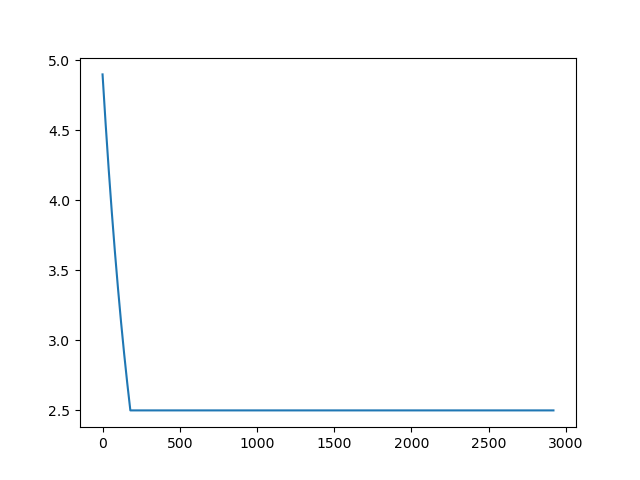

In [54]:
plt.figure()
plt.plot(rbp_2_5_rr_0_25_scenario['rb_onboard_power'])

In [12]:
duration_loop_results = {}
for sim in tqdm(sim_vec):
    kwargs = sim['kwargs']
    return_dict = run_sim(sim['rbp'], sim['rr'], sim['fpr'], **kwargs)
    duration_loop_results[sim['name']] = return_dict

  0%|          | 0/60 [00:00<?, ?it/s]

In [13]:
def filter_df_date(df_in, min_date, max_date):
    df_out = df_in[(df_in['date']>= pd.to_datetime(min_date)) & (df_in['date']<=pd.to_datetime(max_date))]
    return df_out

<IPython.core.display.Javascript object>


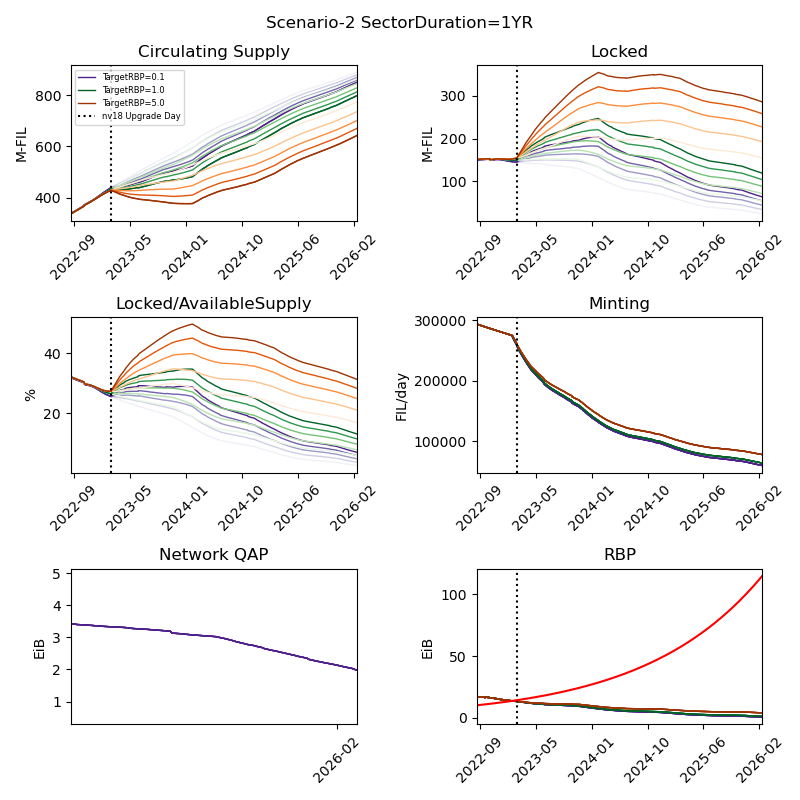

In [60]:
import matplotlib.ticker as plticker
import matplotlib.dates as mdates
import matplotlib.cm as cm

plt_yr = 1
plt_locktargets = lock_targets
plot_scenario=2

if plot_scenario==1:
    plot_scenarios = [
        'Scenario-1',
    ]
    plot_scenario_labels=['MCMC']
    plt_title='Scenario-1 SectorDuration=%dYR' % (plt_yr,)
elif plot_scenario==2:
    plot_scenarios = [
        'Scenario-2_TargetRBP=0.1',
        'Scenario-2_TargetRBP=1.0',
        'Scenario-2_TargetRBP=5.0',
    ]
    plot_scenario_labels = [
        'TargetRBP=0.1',
        'TargetRBP=1.0',
        'TargetRBP=5.0',
    ]
    plt_title='Scenario-2 SectorDuration=%dYR' % (plt_yr,)
elif plot_scenario==3:
    plot_scenarios = [
#         'Scenario-3_TargetRBP=0.1_TargetRR=0.01',  # QAP --> 0, too pessimistic
        'Scenario-3_TargetRBP=2.5_TargetRR=0.25',
        'Scenario-3_TargetRBP=5.0_TargetRR=0.5',
    ]
    plot_scenario_labels = [
#         'TargetRBP=0.1, TargetRR=0.1',
        'TargetRBP=2.5, TargetRR=0.25',
        'TargetRBP=5.0, TargetRR=0.5',
    ]
    plt_title='Scenario-3 SectorDuration=%dYR' % (plt_yr,)

colormap_vecs = ['Purples', 'Greens', 'Oranges']
cmap_access_vec = np.linspace(0.1,0.9,len(plt_locktargets))
linewidth = 1
if plt_yr > 1:
    plt_title = plt_title + ' SDM'

plt.figure(figsize=(8,8))
        
# min_time = current_date
min_time = current_date-datetime.timedelta(days=90)
max_time = datetime.date(2026,3,1)


plt.subplot(3,2,1)
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for jj,lt in enumerate(plt_locktargets):
        c = cmap(cmap_access_vec[jj])
        df_plot = duration_loop_results['%s(%d-Y_%0.02f-LT)' % (plot_scenario,plt_yr,lt)]['rbp_roi']
        df_plot = filter_df_date(df_plot, min_time, max_time)
        plt.plot(df_plot['date'], df_plot['circ_supply'] / MEGA, color=c, linewidth=linewidth)
    # lazy way to create a legend
    plt.plot(df_plot['date'], df_plot['circ_supply'] / MEGA, color=c, linewidth=linewidth, label=plot_scenario_labels[ii])

plt.axvline(intervention_date, linestyle=':', color='k', label='nv18 Upgrade Day')
plt.ylabel('M-FIL')
plt.title('Circulating Supply')
plt.legend(fontsize=6)

ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(3,2,2)
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for jj,lt in enumerate(plt_locktargets):
        c = cmap(cmap_access_vec[jj])
        df_plot = duration_loop_results['%s(%d-Y_%0.02f-LT)' % (plot_scenario,plt_yr,lt)]['rbp_roi']
        df_plot = filter_df_date(df_plot, min_time, max_time)
        plt.plot(df_plot['date'], df_plot['network_locked']/MEGA, label='%0.02f' % (lt,), color=c, linewidth=linewidth)
plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('Locked')
plt.ylabel('M-FIL')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(3,2,3)
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for jj,lt in enumerate(plt_locktargets):
        c = cmap(cmap_access_vec[jj])
        df_plot = duration_loop_results['%s(%d-Y_%0.02f-LT)' % (plot_scenario,plt_yr,lt)]['rbp_roi']
        df_plot = filter_df_date(df_plot, min_time, max_time)
        avail_supply = df_plot['cum_network_reward'] + df_plot['total_vest'] - df_plot['network_gas_burn']
        plt.plot(df_plot['date'], (df_plot['network_locked']/avail_supply * 100), label='%0.02f' % (lt,), color=c, linewidth=linewidth)
plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('Locked/AvailableSupply')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
plt.ylabel('%')

k = 'day_network_reward'; scale=1; ylab_str='FIL/day'; title_str='Minting'
plt.subplot(3,2,4)
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for lt in plt_locktargets:
        c = cmap(cmap_access_vec[jj])
        df_plot = duration_loop_results['%s(%d-Y_%0.02f-LT)' % (plot_scenario,plt_yr,lt)]['rbp_roi']
        df_plot = filter_df_date(df_plot, min_time, max_time)
        plt.plot(df_plot['date'], df_plot[k]/scale, label='%0.02f' % (lt,), color=c, linewidth=linewidth)
        
plt.axvline(intervention_date, linestyle=':', color='k', label='SDM Upgrade Day')
plt.title(title_str)
plt.ylabel(ylab_str)
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)

plt.subplot(3,2,5)
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for lt in plt_locktargets:
        c = cmap(cmap_access_vec[jj])
        df_plot = duration_loop_results['%s(%d-Y_%0.02f-LT)' % (plot_scenario,plt_yr,lt)]['rbp_roi']
        df_plot = filter_df_date(df_plot, min_time, max_time)
        plt.plot(df_plot['date'], df_plot['network_QAP'] / EIB, label='%0.02f' % (lt,), color=c, linewidth=linewidth)

plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('Network QAP')
plt.ylabel('EiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
# max_qap_eib = max_qap / EIB
# plt.ylim(0, max_qap_eib*1.05)
# plt.legend(fontsize=8)


k = 'network_RBP'; title_str='RBP'; scale=EIB; ylab_str = 'EiB'
plt.subplot(3,2,6)
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for lt in plt_locktargets:
        c = cmap(cmap_access_vec[jj])
        df_plot = duration_loop_results['%s(%d-Y_%0.02f-LT)' % (plot_scenario,plt_yr,lt)]['rbp_roi']
        df_plot = filter_df_date(df_plot, min_time, max_time)
        plt.plot(df_plot['date'], df_plot[k]/scale, label='%0.02f' % (lt,), color=c, linewidth=linewidth)
        
plt.axvline(intervention_date, linestyle=':', color='k')

plt.title(title_str)
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.set_xlim(min_time, max_time)
plt.xticks(rotation=45)
# mv = np.nanmax(max_v[max_v != np.inf])
# plt.ylim(0, mv*1.05/scale)
plt.ylabel(ylab_str)

baseline = baseline_storage(df_plot.days * EPOCH_PER_DAY)
plt.plot(df_plot['date'], baseline, color='r')
# plt.yscale('log')

plt.suptitle(plt_title)

plt.tight_layout()
plt.savefig(os.path.join(results_folder, '%s_network_metrics.png' % (plt_title,)))

In [61]:
# setup DFs for USD calculations
df_plot['date'] = pd.to_datetime(df_plot['date'])
price_df_full = get_ts('filecoin')
price_df_full['time_d'] = pd.to_datetime(price_df_full['time_d'])

usd_results = {}
future_usd_prices = [0.1, 3, 25]
for plot_scenario in plot_scenarios:
    for future_price in future_usd_prices:
        for lt in plt_locktargets:
            usd_analysis_df = duration_loop_results['%s(%d-Y_%0.02f-LT)' % (plot_scenario,plt_yr,lt)]['rbp_roi']
            price_df = price_df_full[price_df_full['time_d'] >= pd.to_datetime(usd_analysis_df['date'].min())]

            dft = add_USD_generated_quantities(usd_analysis_df, 
                                               price_df,
                                               costs=0.0, 
                                               future_price=future_price,
                                               duration_yr=plt_yr,
                                              )
            dft['price'] = future_price

            k='%s Y=%d LT=%0.02f FutureUSDPrice=%0.02f' % (plot_scenario, plt_yr, lt, future_price)
            usd_results[k] = copy.deepcopy(dft)

<IPython.core.display.Javascript object>


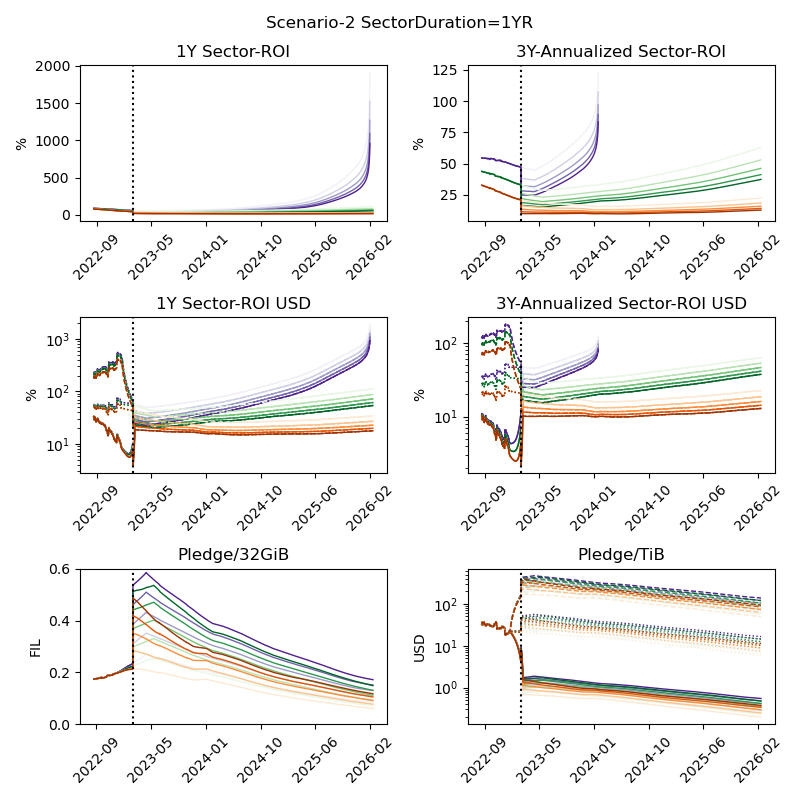

In [62]:
linestyle_vec = ['-', ':', '--', '-.']
plt.figure(figsize=(8,8))

plt.subplot(3,2,1)
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for jj,lt in enumerate(plt_locktargets):
        c = cmap(cmap_access_vec[jj])
        k='%s Y=%d LT=%0.02f FutureUSDPrice=%0.02f' % (plot_scenario, plt_yr, lt, future_usd_prices[0])
        df_plot = usd_results[k]
        df_plot = filter_df_date(df_plot, min_time, max_time)
        plt.plot(df_plot['date'], df_plot['1y_sector_roi']*100, color=c, linewidth=linewidth)
    
plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('1Y Sector-ROI')
plt.ylabel('%')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
# plt.ylim(0,80)

plt.subplot(3,2,2)
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for jj,lt in enumerate(plt_locktargets):
        c = cmap(cmap_access_vec[jj])
        k='%s Y=%d LT=%0.02f FutureUSDPrice=%0.02f' % (plot_scenario, plt_yr, lt, future_usd_prices[0])
        df_plot = usd_results[k]
        df_plot = filter_df_date(df_plot, min_time, max_time)
        plt.plot(df_plot['date'], df_plot['3y_roi_annualized']*100, color=c, linewidth=linewidth)

plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('3Y-Annualized Sector-ROI')
plt.ylabel('%')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
# plt.ylim(0,80)

plt.subplot(3,2,3)
for pp, usd_price in enumerate(future_usd_prices):
    linestyle=linestyle_vec[pp]
    for ii, plot_scenario in enumerate(plot_scenarios):
        cmap = cm.get_cmap(colormap_vecs[ii])
        for jj,lt in enumerate(plt_locktargets):
            c = cmap(cmap_access_vec[jj])    
            k='%s Y=%d LT=%0.02f FutureUSDPrice=%0.02f' % (plot_scenario, plt_yr, lt, usd_price)
            df_plot = usd_results[k]
            df_plot = filter_df_date(df_plot, min_time, max_time)
            plt.plot(df_plot['date'], df_plot['1y_sector_roi_USD']*100, color=c, linestyle=linestyle, linewidth=linewidth)

plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('1Y Sector-ROI USD')
plt.ylabel('%')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.yscale('log')
# plt.ylim(0,80)

plt.subplot(3,2,4)
color_vec = []
for pp, usd_price in enumerate(future_usd_prices):
    linestyle=linestyle_vec[pp]
    for ii, plot_scenario in enumerate(plot_scenarios):
        cmap = cm.get_cmap(colormap_vecs[ii])
        for jj,lt in enumerate(plt_locktargets):
            c = cmap(cmap_access_vec[jj])    
            
            k='%s Y=%d LT=%0.02f FutureUSDPrice=%0.02f' % (plot_scenario, plt_yr, lt, usd_price)
            df_plot = usd_results[k]
            df_plot = filter_df_date(df_plot, min_time, max_time)
            plt.plot(df_plot['date'], df_plot['3y_sector_roi_USD_annualized']*100, color=c, linewidth=linewidth, linestyle=linestyle)

plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('3Y-Annualized Sector-ROI USD')
plt.ylabel('%')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.yscale('log')
# plt.ylim(0,80)

plt.subplot(3,2,5)
kek='day_pledge_per_QAP'
for ii, plot_scenario in enumerate(plot_scenarios):
    cmap = cm.get_cmap(colormap_vecs[ii])
    for jj,lt in enumerate(plt_locktargets):
        c = cmap(cmap_access_vec[jj])
        df_plot = duration_loop_results['%s(%d-Y_%0.02f-LT)' % (plot_scenario,plt_yr,lt)]['rbp_roi']
        df_plot = filter_df_date(df_plot, min_time, max_time)
        plt.plot(df_plot['date'].iloc[1:], df_plot[kek].iloc[1:], label='%0.02f' % (lt,), color=c, linewidth=linewidth)

plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('Pledge/32GiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
plt.ylim(0, 0.6)
plt.ylabel('FIL')

plt.subplot(3,2,6)
kek='day_pledge_per_TIB_USD'
color_vec = []
for pp, usd_price in enumerate(future_usd_prices):
    linestyle=linestyle_vec[pp]
    for ii, plot_scenario in enumerate(plot_scenarios):
        cmap = cm.get_cmap(colormap_vecs[ii])
        for jj,lt in enumerate(plt_locktargets):
            c = cmap(cmap_access_vec[jj])    
            
            k='%s Y=%d LT=%0.02f FutureUSDPrice=%0.02f' % (plot_scenario, plt_yr, lt, usd_price)
            df_plot = usd_results[k]
            df_plot = filter_df_date(df_plot, min_time, max_time)
            plt.plot(df_plot['date'], df_plot[kek], color=c, linewidth=linewidth, linestyle=linestyle)

plt.axvline(intervention_date, linestyle=':', color='k')
plt.title('Pledge/TiB')
ax = plt.gca()
loc = plticker.MultipleLocator(base=250.0) # this locator puts ticks at regular intervals
ax.xaxis.set_major_locator(loc)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.xticks(rotation=45)
# plt.ylim(0, 0.4)
plt.ylabel('USD')
plt.yscale('log')

plt.suptitle(plt_title)

plt.tight_layout()
plt.savefig(os.path.join(results_folder, '%s_sp_metrics.png' % (plt_title, )))